In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# Load data
df = pd.read_excel(r'/Users/marclambertes/Downloads/Wyscout/Premier League 2023-2024.xlsx', index_col='Player')
df = df[df['Minutes played'] >= 500]

# Optional filtering
# df = df[df['League'] == 'Eredivisie']
# df = df[(df['League'] != 'Belarus') & (df['League'] != 'Russian Super League') & (df['League'] != 'Ukraine')]
# df = df[(df['Team'] != 'Chelsea')]

# Drop columns
cols_to_drop = ['Minutes played', 'Matches played', 'Birth country',
                'Passport country', 'Height', 'Weight']
df = df.drop(columns=cols_to_drop)

# Handle missing values
if df.isna().values.any():
    df = df.fillna(0)

# Separate numeric vs. categorical columns
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
df = df[['Team', 'Team within selected timeframe', 'Position'] + num_cols]

# Scale numeric features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Calculate Euclidean distance matrix
eucl_dist = pairwise_distances(df[num_cols], metric='euclidean')

def get_similar_players(player_name, top_n=300):
    """
    Returns a list of tuples: (PlayerName, Team, Position, Distance)
    Sorted from smallest to largest distance.
    """
    index = df.index.get_loc(player_name)
    
    # Get distances from 'player_name' to every other player
    dist_scores = list(enumerate(eucl_dist[index]))
    
    # Sort by ascending distance (most similar first)
    dist_scores = sorted(dist_scores, key=lambda x: x[1])
    
    # Slice out the top_n (skipping index 0, which is the player themself)
    top_scores = dist_scores[1:top_n + 1]
    
    # Build the list of (player, team, position, distance)
    similar_players = [
        (df.index[i], 
         df.iloc[i]['Team within selected timeframe'],
         df.iloc[i]['Position'], 
         dist
        ) 
        for i, dist in top_scores
    ]
    return similar_players

# Prompt user for player name
player_name = input("Enter a player name: ")
similar_players = get_similar_players(player_name)

# Convert Euclidean distance to a 0-100 “similarity” scale
# Formula: similarity = 100 * (1 - distance / max_distance)
# so that the largest distance -> 0% similarity, and the smallest distance -> ~100%.
max_distance = max(similar_players, key=lambda x: x[3])[3]
similar_players = [
    (
        player, 
        team, 
        position, 
        100 * (1 - (dist / max_distance))  # scale to 0–100
    )
    for (player, team, position, dist) in similar_players
]

# Print similar players
print(f"Players similar to {player_name}:")
for player, team, position, similarity_score in similar_players:
    print(f"Player: {player}")
    print(f"Team: {team}")
    print(f"Position: {position}")
    print(f"Similarity Score: {similarity_score:.2f}%\n")

# Write similar players to Excel
output_filename = r'/Users/marclambertes/Python/similar players.xlsx'
similar_players_df = pd.DataFrame(
    similar_players, 
    columns=['Player', 'Team', 'Position', 'Similarity Score']
)
similar_players_df.to_excel(output_filename, index=False)
print(f"Similar players saved to {output_filename}")


Enter a player name: Mohamed Salah
Players similar to Mohamed Salah:
Player: C. Palmer
Team: Chelsea
Position: AMF, RAMF
Similarity Score: 55.91%

Player: Son Heung-Min
Team: Tottenham Hotspur
Position: CF, LAMF
Similarity Score: 54.71%

Player: João Pedro
Team: Brighton
Position: CF, AMF
Similarity Score: 49.40%

Player: B. Saka
Team: Arsenal
Position: RWF, RW
Similarity Score: 48.14%

Player: D. Núñez
Team: Liverpool
Position: CF
Similarity Score: 45.17%

Player: B. Mbeumo
Team: Brentford
Position: RWF, CF
Similarity Score: 44.06%

Player: L. Bailey
Team: Aston Villa
Position: RW, RAMF
Similarity Score: 42.22%

Player: L. Trossard
Team: Arsenal
Position: LWF, CF, LW
Similarity Score: 41.40%

Player: J. Álvarez
Team: Manchester City
Position: CF, AMF
Similarity Score: 40.47%

Player: M. Ødegaard
Team: Arsenal
Position: RCMF
Similarity Score: 40.39%

Player: Bruno Fernandes
Team: Manchester United
Position: AMF, CF, LCMF
Similarity Score: 40.30%

Player: A. Isak
Team: Newcastle United


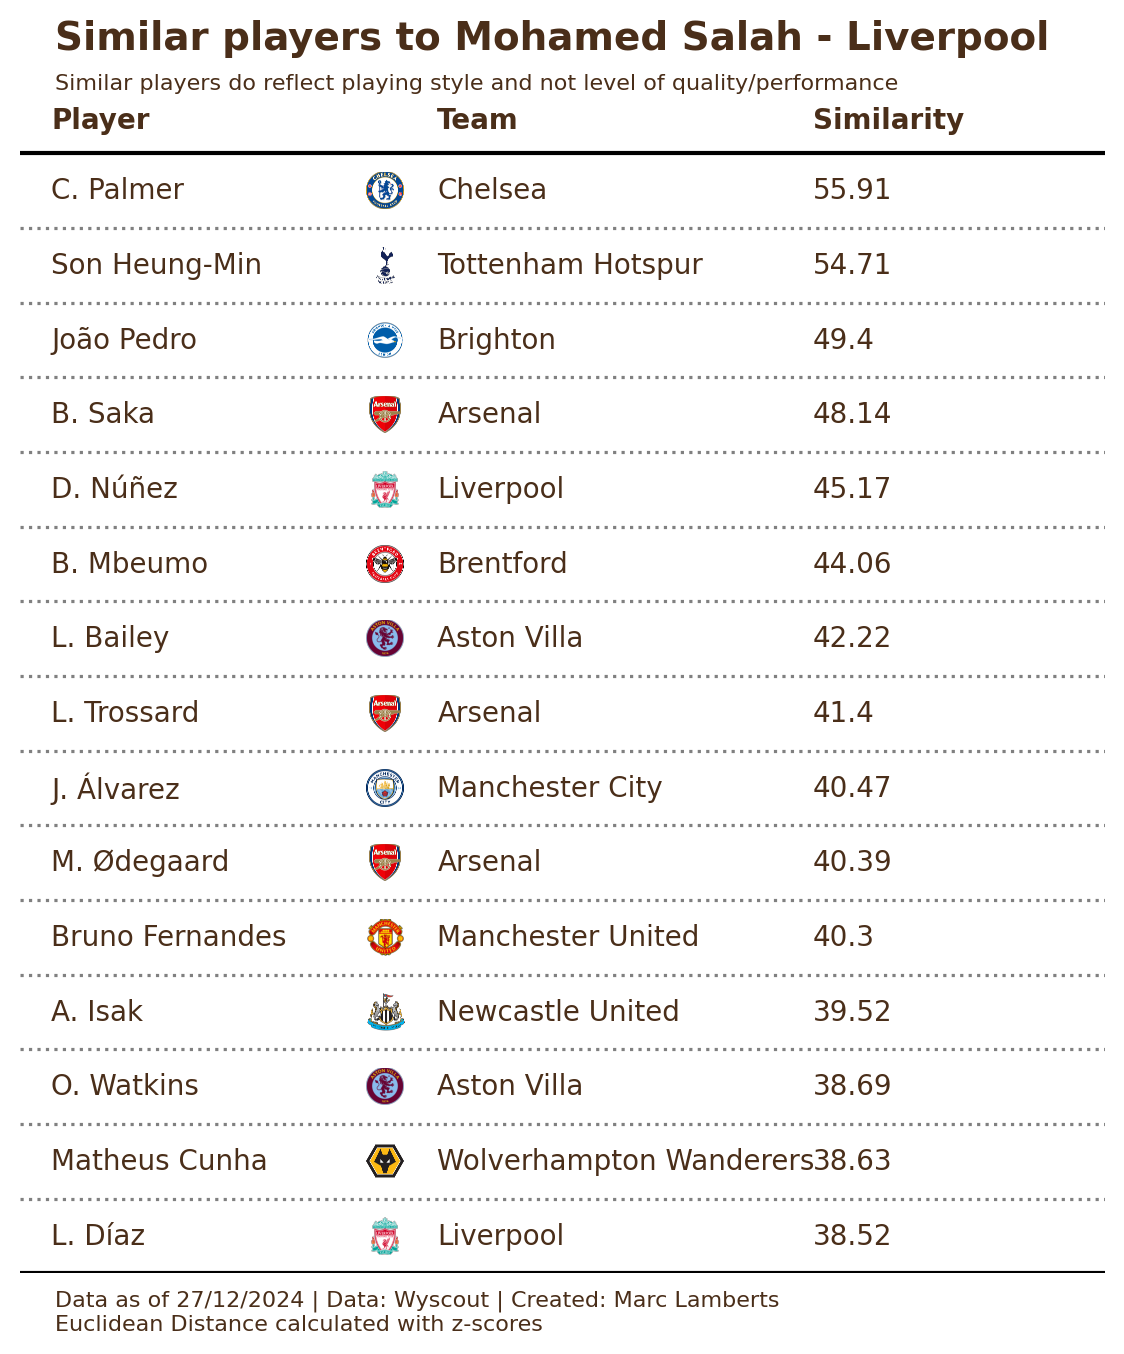

In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/Python/similar players.xlsx')
#df['League'] = df['League'].str.split(' - ').str[0]

#df = df[(df['League'] != 'Armenia')]
#df = df[df['Age'] <= 23]

df = df.rename(columns={'Similarity Score': 'Similarity'})
def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax
df['Similarity'] = (df['Similarity']).round(2)



indexdf = df.head(15)[['Player', 'Team', 'Similarity']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Team'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.87,
    s='Similar players to Mohamed Salah - Liverpool',
    ha='left',
    va='bottom',
    weight='bold',
    size=14, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 27/12/2024 | Data: Wyscout | Created: Marc Lamberts\nEuclidean Distance calculated with z-scores',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

fig.text(
    x=0.15, y=0.86,
    s='Similar players do reflect playing style and not level of quality/performance',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('Similar Players - Mohamed Salah2.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')
